In [256]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

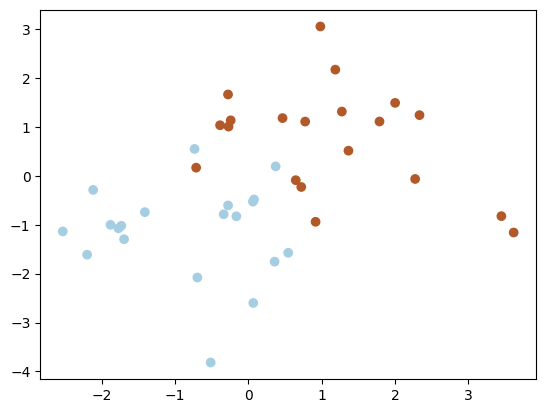

In [257]:
# 数据准备
NUM = 20
# np.random.seed(1)
x1 = np.random.randn(NUM,2)+[1,1]
x2 = np.random.randn(NUM,2)-[1,1]
X = np.concatenate((x1,x2),axis=0)
y = np.concatenate((np.ones(NUM),-np.ones(NUM)),axis=0)
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.Paired)
ax = plt.gca()

C = 1 # 惩罚系数
tol = 0.001 # 容忍度
max_iter = 1000 # 最大迭代次数
m,n = X.shape # m个样本，n个特征
alpha = np.zeros(m) # 初始化拉格朗日乘子
b = 0 # 初始化截距
iters = 0 # 初始化迭代数


In [250]:
def kernel(x,y,type='linear'):
    if type == 'linear':
        result = np.dot(x,y)
    return result

def f_i(num,alpha,b):
    result = np.dot(alpha*y,kernel(X,X[num]))+b
    return result

def Error(num,alpha,b):
    result = f_i(num,alpha,b)-y[num]
    return result

def KKT_error_distance(num,alpha,b):
    if alpha[num] == 0:
        delta = y[num]*f_i(num,alpha,b) - 1
        if delta < 0:
            return abs(delta)
        else:
            return 0
    elif alpha[num] > 0 and alpha[num] < C:
        delta = y[num]*f_i(num,alpha,b) - 1
        if delta == 0:
            return 0
        else:
            return abs(delta)
    elif alpha[num] == C:
        delta = y[num]*f_i(num,alpha,b) - 1
        if delta > 0:
            return abs(delta)
        else:
            return 0
        
def KKT_error(X,alpha,b,type='max'):
    result = []
    for i in range(np.shape(X)[0]):
        result.append([KKT_error_distance(i,alpha,b),i])
    result = pd.DataFrame(result)
    if type == 'max':
        result = result.sort_values(by=[0,1])
        result = [result.iloc[-1].name,result.iloc[-1].values[0]]
        return result
    if type == 'list':
        return result

def E_choice(num,alpha,b,type='choice'):
    result = []
    for i in range(np.shape(X)[0]):
        result.append([Error(i,alpha,b),i])
    result = pd.DataFrame(result).sort_values(by=[0,1])
    E1 = Error(num,alpha,b)
    if type == 'choice':
        if E1 > 0:
            result = [result.iloc[0].name,result.iloc[0].values[0]]
        elif E1 < 0:
            result = [result.iloc[-1].name,result.iloc[-1].values[0]]
        return result
    if type == 'list':
        return result

def choice_i_j(X,alpha,b):
    i = KKT_error(X,alpha,b)[0]
    j = E_choice(i,alpha,b)[0]
    return i,j

def eta(i,j):
    result = kernel(X[i],X[i]) + kernel(X[j],X[j]) - 2*kernel(X[i],X[j])
    return result

def cut_off(alpha_old,i,j,Ei_old,Ej_old):
    if y[i] != y[j]:
        L = max(0,alpha_old[j]-alpha_old[i])
        H = min(C,C+alpha_old[j]-alpha_old[i])
    else:
        L = max(0,alpha_old[j]+alpha_old[i]-C)
        H = min(C,alpha_old[j]+alpha_old[i])
    alpha_j = alpha_old[j] + y[j]*(Ei_old-Ej_old)/eta(i,j)
    alpha_j = min(alpha_j,H)
    alpha_j = max(alpha_j,L)
    return alpha_j

In [268]:
i,j = choice_i_j(X,alpha,b)

Ei_old = Error(i,alpha,b)
Ej_old = Error(j,alpha,b)
alpha_old = alpha.copy()
alpha_new = alpha.copy()

alpha_new[j] = cut_off(alpha_old,i,j,Ei_old,Ej_old)
if abs(alpha_new[j]-alpha_old[j]) < 0.0001:
    while True:
        index = np.arange(0,X.shape[0],1)
        num = np.random.choice(index)
        if num!= i:
            break
# if abs(alpha_new[j]-alpha_old[j]) < 0.0001:
#     pd_alpha = pd.DataFrame(alpha)
#     for num in pd_alpha[C > pd_alpha > 0].dropna().index:
#         if num == i:
#             continue
#         if num != i:
#             break
#     j = num
#     Ej_old = Error(j,alpha,b)
#     alpha_new[j] = cut_off(alpha_old,i,j,Ei_old,Ej_old)
alpha_new[i] = alpha_old[i] + y[i]*y[j]*(alpha_old[j]-alpha_new[j])

b1 = b - Ei_old - y[i]*(alpha_new[i]-alpha_old[i])*kernel(X[i],X[i]) - y[j]*(alpha_new[j]-alpha_old[j])*kernel(X[i],X[j])
b2 = b - Ej_old - y[i]*(alpha_new[i]-alpha_old[i])*kernel(X[i],X[j]) - y[j]*(alpha_new[j]-alpha_old[j])*kernel(X[j],X[j])

if 0 < alpha[i] < C and 0 < alpha[j] < C:
    b = b1
else:
    b = (b1+b2)/2

alpha = alpha_new.copy()

w = np.dot(alpha*y,X)

E = E_choice(i,alpha,b,'list')
KKT = KKT_error(X,alpha,b,'list')
print(i,j)

19 1


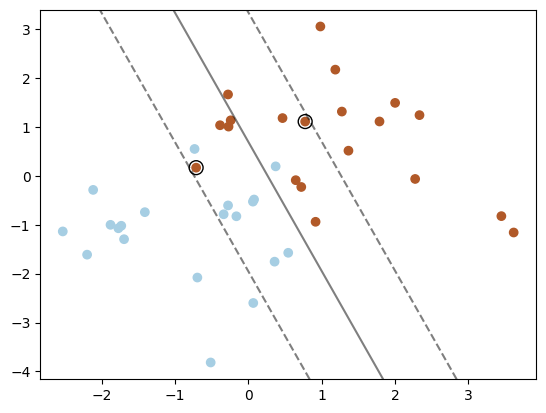

In [269]:
# 绘制数据集和决策边界
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# 生成网格点并预测分类
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = np.dot(xy, w.T) + b

# 绘制决策边界和支持向量
Z = Z.reshape(XX.shape)
plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
plt.scatter(X[np.where(np.abs(np.dot(X, w.T) + b - 1) < 0.1)[0], 0],
            X[np.where(np.abs(np.dot(X, w.T) + b - 1) < 0.1)[0], 1],
            marker='o', s=100, edgecolors='k', facecolors='none')
plt.scatter(X[np.where(np.abs(np.dot(X, w.T) + b + 1) < 0.1)[0], 0],
            X[np.where(np.abs(np.dot(X, w.T) + b + 1) < 0.1)[0], 1],
            marker='o', s=100, edgecolors='k', facecolors='none')